In [1]:
import os

# Set Kaggle API key and username
os.environ['KAGGLE_USERNAME'] = 'KAGGLE_USERNAME'
os.environ['KAGGLE_KEY'] = 'KAGGLE_KEY'

In [2]:
!kaggle datasets download -d emmarex/plantdisease


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 650M/658M [00:10<00:00, 37.0MB/s]
100% 658M/658M [00:10<00:00, 64.3MB/s]


In [3]:
from zipfile import ZipFile
file_name = "/content/plantdisease.zip" # Changed the file name to the correct one.
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import os
import shutil

# Set the path to the dataset directory
dataset_dir = "/content/PlantVillage"

# List all directories in the dataset
directories = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# Specify the directories you want to delete (all paths should be relative to dataset_dir)
directories_to_delete = [
    "Pepper__bell___Bacterial_spot",
    "Pepper__bell___healthy",
    "Potato___Early_blight",
    "Potato___healthy",
    "Potato___Late_blight",
]

# Iterate over the directories and delete them along with their contents
for directory in directories_to_delete:
    directory_path = os.path.join(dataset_dir, directory)
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Deleted directory: {directory_path}")
    else:
        print(f"Directory not found: {directory_path}")


Deleted directory: /content/PlantVillage/Pepper__bell___Bacterial_spot
Deleted directory: /content/PlantVillage/Pepper__bell___healthy
Deleted directory: /content/PlantVillage/Potato___Early_blight
Deleted directory: /content/PlantVillage/Potato___healthy
Deleted directory: /content/PlantVillage/Potato___Late_blight


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tensorflow.keras instead of just keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.applications.vgg16 import preprocess_input # Use tensorflow.keras instead of just keras
from tensorflow.keras.preprocessing import image # Use tensorflow.keras instead of just keras
# from keras.preprocessing.image import ImageDataGenerator # No longer needed
from tensorflow.keras.models import Sequential # Use tensorflow.keras instead of just keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
import cv2
from tensorflow.keras.utils import load_img, img_to_array # Use tensorflow.keras instead of just keras
import tensorflow as tf


**Directories & Classes**<br>
These are the path of the dataset innter folders and classes in the given dataset

In [6]:
DIRECTORY = r'/content/'
FOLDERS = ['PlantVillage']
CLASSES = ['Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Leaf_Mold',
 'Tomato_Bacterial_spot',
 'Tomato_Late_blight',
 'Tomato_Early_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']


**Load Data**<br>
The given code is loading the training and validation data from the dataset and convert these images to array with the size of 256x256 and append each image datain train_data, and val_data list. I have loaded just 2500 images from eaach class due to limitted resources.


In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3


In [10]:
data = []
for folder in FOLDERS:
  folder_path = os.path.join(DIRECTORY, folder)
  for classification in CLASSES:
    image_path = os.path.join(folder_path, classification)
    images = os.listdir(image_path)
    images = images[:500]
    for image in images:
      try:
        image_url = os.path.join(image_path, image)
        arr = cv2.imread(image_url)
        arr = cv2.resize(arr, (IMAGE_SIZE,IMAGE_SIZE))
        label = CLASSES.index(classification)
        data.append([arr, label])
      except Exception as e:
        print("Error : ",e)

Error :  OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [11]:
len(data)

4872

In [12]:
classes_names = CLASSES
print(classes_names)

['Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


**Mix Images of both classes**<br>
In the above list the image is append in squence at the top inital images are fractured bones and the remaining are not fractrued bone to train model in best way i have suffle the images

In [13]:
import random
random.shuffle(data)


**Seperate Dependent & Independent Data**

In [14]:
X = []
y = []
for feature, label in data:
  X.append(feature)
  y.append(label)


In [15]:


X = np.array(X)
y = np.array(y)


In [16]:
X.shape

(4872, 224, 224, 3)

In [17]:
y.shape

(4872,)

**Function to Split Dataset**
Dataset should be bifurcated into 3 subsets, namely:<br>

**Training:** Dataset to be used while training<br>

**Test**: Dataset to be tested against after we trained a mo

In [18]:

from sklearn.model_selection import train_test_split

# Assuming you have your data stored in X and corresponding labels in y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [19]:
len(X_train)

4384

In [20]:
len(y_train)

4384

In [21]:

len(X_test)

488

In [22]:
len(y_test)

488

In [23]:
print(y_train.shape)  # Check shape of y_train
print(X_train.shape)  # Check shape of X_train



(4384,)
(4384, 224, 224, 3)



**Data Augmentation**<br>
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [24]:

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Print the shapes to verify
print(f"Training data shape: {X_train_split.shape}, {y_train_split.shape}")
print(f"Validation data shape: {X_val_split.shape}, {y_val_split.shape}")


Training data shape: (3507, 224, 224, 3), (3507,)
Validation data shape: (877, 224, 224, 3), (877,)


In [25]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,           # Normalize pixel values to [0, 1]
    rotation_range=20,            # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,        # Randomly shift images horizontally by 20%
    height_shift_range=0.2,       # Randomly shift images vertically by 20%
    shear_range=0.2,              # Shear transformation
    zoom_range=0.2,                 # Random zoom
    horizontal_flip=True,         # Flip images horizontally
)

# For validation, we don't apply augmentation, only rescaling (if needed)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [26]:
from tensorflow.keras.utils import to_categorical
# Convert labels to one-hot encoding
y_train_split = to_categorical(y_train_split, num_classes=10)
y_val_split = to_categorical(y_val_split, num_classes=10)

In [27]:
# Training generator
train_generator = train_datagen.flow(
    x=X_train_split,
    y=y_train_split,
    batch_size=32
)

# Validation generator
val_generator = val_datagen.flow(
    x=X_val_split,
    y=y_val_split,
    batch_size=32
)


In [28]:
print(f"Number of training samples: {train_generator.n}")
print(f"Number of validation samples: {val_generator.n}")

Number of training samples: 3507
Number of validation samples: 877


**Resnet 50**

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to create the model with a given base model
def create_model(base_model):
    base_model.trainable = False  # Freeze the base model layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    output_layer = Dense(10, activation='softmax')(x)  # Adjust output units to match your classes
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model



# ResNet50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = create_model(resnet_base)
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=[tf.keras.metrics.CategoricalAccuracy()])



print("\nResNet50 Model Summary")
resnet_model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

ResNet50 Model Summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:
# Train the ResNet50 model
print("\nTraining ResNet50 Model")
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)




Training ResNet50 Model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 515ms/step - categorical_accuracy: 0.1072 - loss: 2.3936 - val_categorical_accuracy: 0.1380 - val_loss: 2.2942
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - categorical_accuracy: 0.1159 - loss: 2.2942 - val_categorical_accuracy: 0.1334 - val_loss: 2.2888
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - categorical_accuracy: 0.1192 - loss: 2.2922 - val_categorical_accuracy: 0.1482 - val_loss: 2.2738
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 84s 377ms/step - categorical_accuracy: 0.1309 - loss: 2.2807 - val_categorical_accuracy: 0.1562 - val_loss: 2.2587
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 371ms/step - categorical_accuracy: 0.1289 - loss: 2.2731 - val_categorical_accuracy: 0.1642 - val_loss: 2.2488
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 383ms/step - categorical_accuracy: 0.1267 - loss: 2.2580 - val_categorical_accuracy: 0.1870 - val_loss: 2.2286
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 365ms/step - categorical_accuracy: 0.

In [31]:
# Assuming y_test_raw contains class indices
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Verify the shape
print("y_test shape after one-hot encoding:", y_test.shape)


y_test shape after one-hot encoding: (488, 10)


In [32]:
test_loss, test_accuracy = resnet_model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - categorical_accuracy: 0.0886 - loss: 9.5750


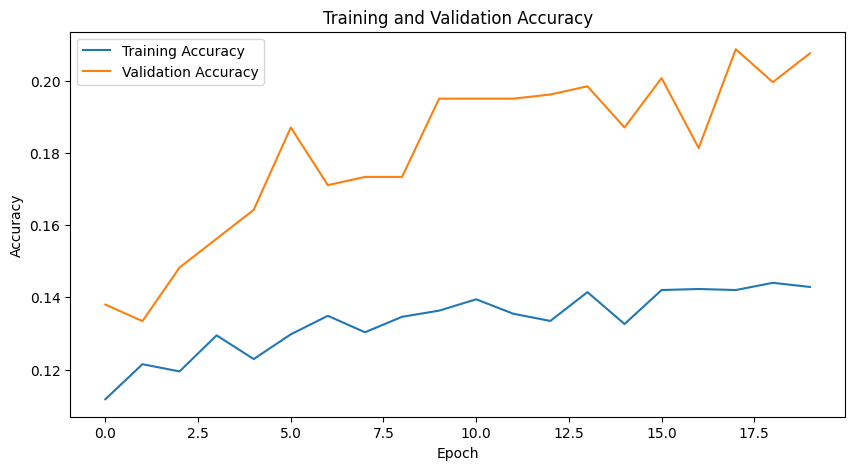

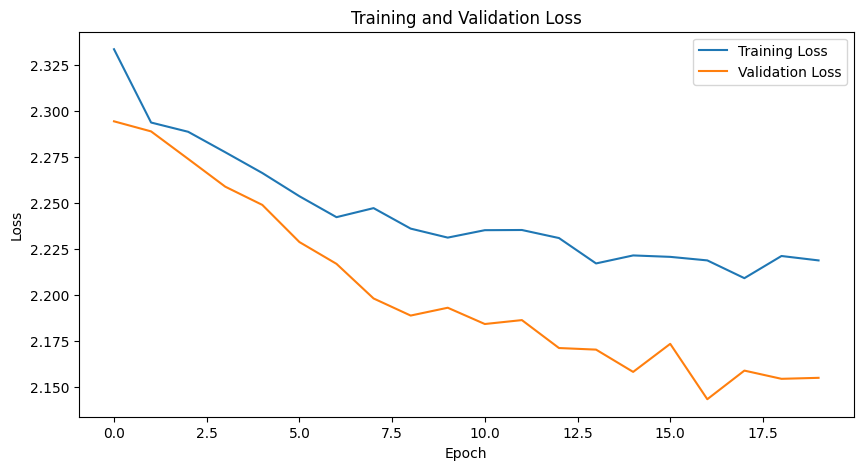

In [35]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(resnet_history.history['categorical_accuracy'], label='Training Accuracy') # Changed 'accuracy' to 'categorical_accuracy'
plt.plot(resnet_history.history['val_categorical_accuracy'], label='Validation Accuracy') # Changed 'val_accuracy' to 'val_categorical_accuracy'
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


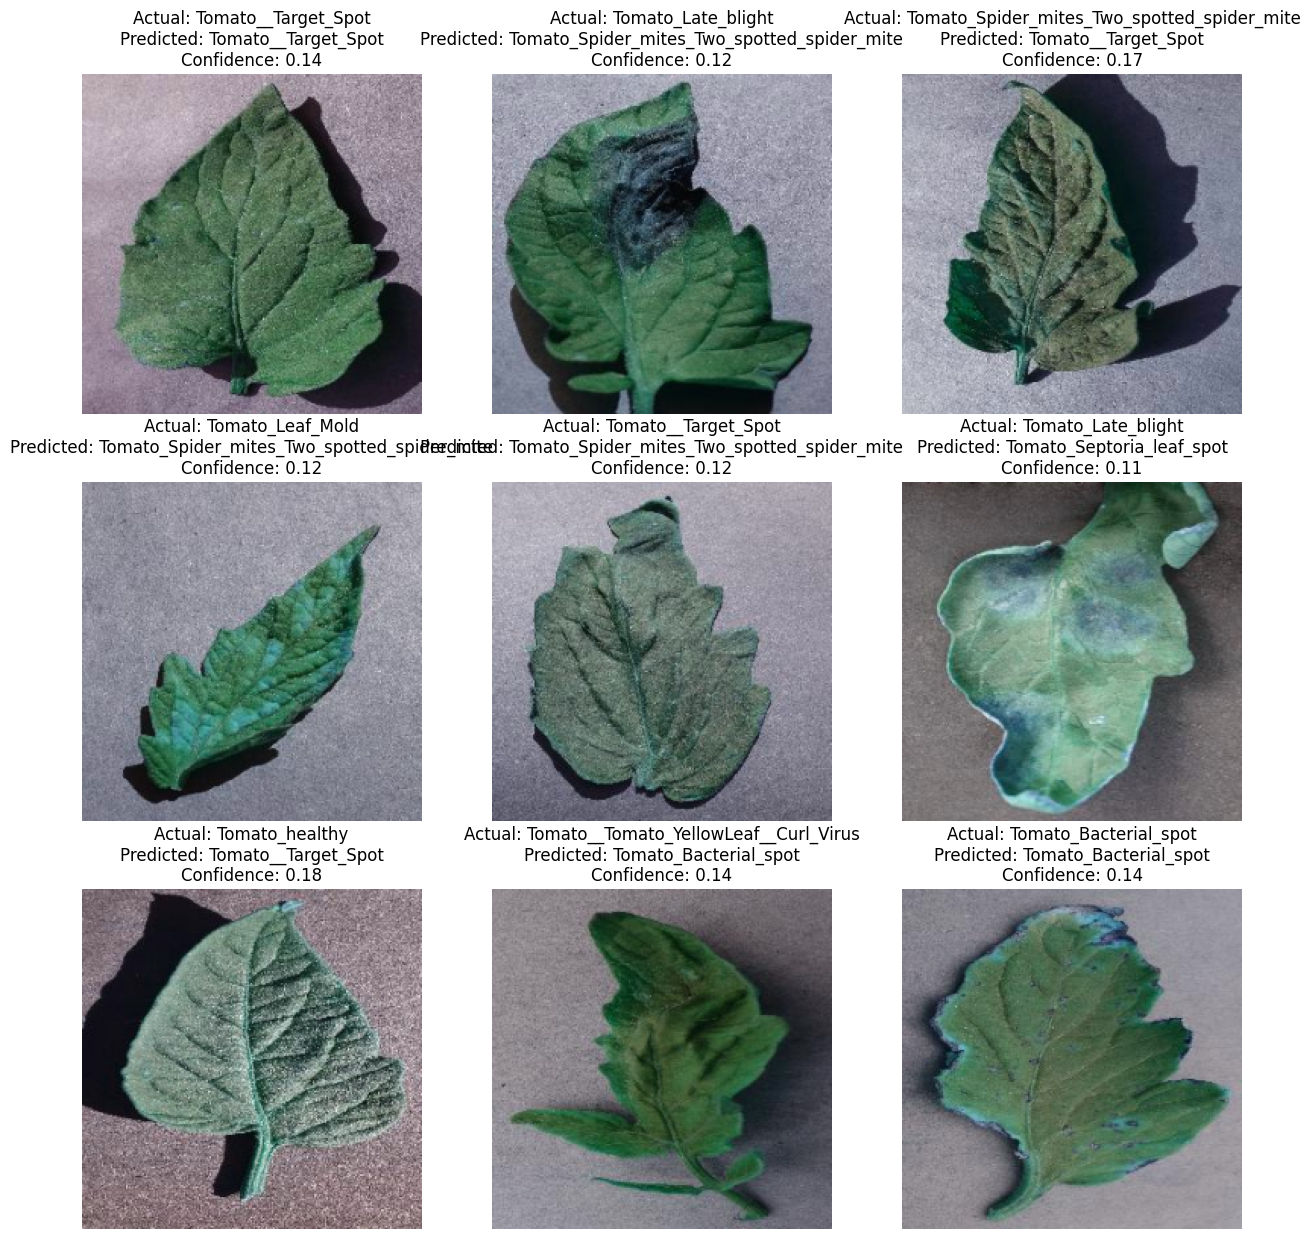

In [36]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

# Use the existing CLASSES variable, no need to redefine
# CLASSES = list(train_generator.class_indices.keys())  # Remove this line

def predict(model, image):
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class_index = tf.argmax(prediction[0]).numpy()
    confidence = tf.reduce_max(prediction[0]).numpy()
    predicted_class = CLASSES[predicted_class_index] # 'CLASSES' is the global variable
    return predicted_class, confidence


# Use a generator to feed data to the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(
    x=X_test,
    y=y_test,  # Use one-hot encoded y_test here
    batch_size=9,  # Batch size for testing
    shuffle=False  # Important for consistent order of prediction
)

X_test_batch, y_test_batch = next(test_generator)

plt.figure(figsize=(15, 15))
for index, image in enumerate(X_test_batch):
    if index < 9:
        ax = plt.subplot(3, 3, index + 1)
        plt.imshow(image)
        predicted_class, confidence = predict(resnet_model, image)

        # Get the actual class label from the one-hot encoded y_test
        label = tf.argmax(y_test_batch[index]).numpy()
        actual_class = CLASSES[label] # 'CLASSES' is the global variable

        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}')
        plt.axis('off')
    else:
        break
plt.show()